In [1]:
import sys
import os
import json

sys.path.insert(1, 'litepose-pose-estimation/src')

from lp_coco_utils.lp_getDataset import getDatasetProcessed
from lp_training.lp_trainer import train
from lp_model.lp_litepose import LitePose
from lp_inference.lp_inference import inference, assocEmbedding
from lp_utils.lp_image_processing import drawHeatmap, drawKeypoints, drawSkeleton
from lp_testing.lp_evaluate import evaluateModel

import lp_config.lp_common_config as cc
import torch
import cv2

from thop import profile

from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlopen

from torchvision import transforms

In [2]:
# Leggo il file di configurazione
with open('config/config.json') as f:
    config_data = json.load(f)

# Ottengo i percorsi dei file
file_path_big_arch = config_data['path_big_arch']

In [3]:
# Carico il modello già addestrato

model = LitePose().to(cc.config["device"])
model.load_state_dict(torch.load(file_path_big_arch, map_location=cc.config["device"]))

<All keys matched successfully>

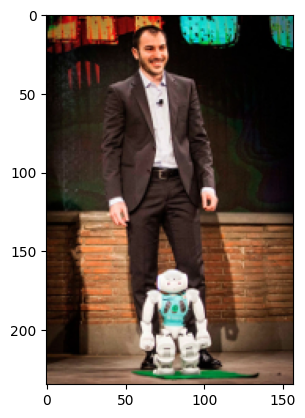

In [9]:
url = 'https://web.unibas.it/bloisi/assets/images/bloisi_nao.jpg'

img = Image.open(urlopen(url)).convert('RGB')
plt.grid(False)
_= plt.imshow(img)

In [10]:
# set up transformation to resize the image
resize = transforms.Resize([224, 224])
img = resize(img)
to_tensor = transforms.ToTensor()

# apply transformation and convert to Pytorch tensor
tensor = to_tensor(img)
# torch.Size([3, 224, 224])

# add another dimension at the front to get NCHW shape
tensor = tensor.unsqueeze(0)
# torch.Size([1, 3, 224, 224])

In [11]:
output, keypoints = inference(model, tensor)
embedding = assocEmbedding(keypoints)